# Imports

In [ ]:
# !pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg pillow opencv-python

In [426]:
# Naudotos technologijos
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
%matplotlib inline

import glob

import matplotlib

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import pydicom
import random

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.optimizers import RMSprop

from tqdm import tqdm
import cv2
from joblib import Parallel, delayed
import shutil

from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage.transform import resize
import skimage
from PIL import Image
import PIL

2.11.0


In [427]:
print("NumPy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Matplotlib version: ", matplotlib.__version__)
print("Pydicom version: ", pydicom.__version__)
print("TensorFlow version: ", tf.__version__)
print("OpenCV version: ", cv2.__version__)
print("PIL version: ", PIL.__version__)
print("Scikit-Image version: ", skimage.__version__)

NumPy version:  1.21.6
Pandas version:  1.3.5
Matplotlib version:  3.5.3
Pydicom version:  2.3.1
TensorFlow version:  2.11.0
OpenCV version:  4.7.0
PIL version:  9.5.0
Scikit-Image version:  0.19.3


In [428]:
SEED = 42
def seeding(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Downloading weights

In [371]:
# !wget --no-check-certificate \
#     https://github.com/fchollet/deep-learning-models/releases/download/v0.7/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5

# Configs

In [429]:
target_size = 299
batch_size = 64

lr_max = 6e-6 * 8
wd_ratio = 0.01

epochs = 15

# # All images extracted from DICOM folder
# images_folder = "images/"
# os.makedirs(images_folder, exist_ok=True)

# Helper functions


In [430]:
import tensorflow as tf

# Pakalbėti apie ROI, pavaizduoti prieš ir po vaizdus.
def img2roi(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Binarize the image
    bin_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]

    # Make contours around the binarized image, keep only the largest contour
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

    # Find ROI from largest contour
    ys = contour.squeeze()[:, 0]
    xs = contour.squeeze()[:, 1]
    roi =  img[np.min(xs):np.max(xs), np.min(ys):np.max(ys)]
    
    roi = cv2.resize(roi, (img.shape[1], img.shape[0]))
    roi = cv2.cvtColor(roi,cv2.COLOR_GRAY2RGB)
#     roi = np.expand_dims(roi, axis =-1)
    return roi

# DCIM to png

In [374]:
# # Implementation from https://www.kaggle.com/code/theoviel/dicom-resized-png-jpg
# Dataset from https://www.kaggle.com/c/rsna-breast-cancer-detection
# import os
# import cv2
# import glob
# import gdcm
# import pydicom
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
# from joblib import Parallel, delayed

In [375]:
# train_images = glob.glob("/kaggle/input/rsna-breast-cancer-detection/train_images/*/*.dcm")

# len(train_images)

In [376]:
# for f in tqdm(train_images[:3]):
#     patient = f.split('/')[-2]
#     image = f.split('/')[-1][:-4]

#     dicom = pydicom.dcmread(f)
#     img = dicom.pixel_array

#     img = (img - img.min()) / (img.max() - img.min())

#     if dicom.PhotometricInterpretation == "MONOCHROME1":
#         img = 1 - img
        
#     plt.figure(figsize=(15, 15))
#     plt.imshow(img, cmap="gray")
#     plt.title(f"{patient} {image}")
#     plt.show()

Images are quite big so resizing them is necessary.

* **Will use 299 to train data for InceptionResNetV2**

In [377]:
# def process(f, size=512, save_folder="", extension="png"):
#     patient = f.split('/')[-2]
#     image = f.split('/')[-1][:-4]

#     dicom = pydicom.dcmread(f)
#     img = dicom.pixel_array

#     img = (img - img.min()) / (img.max() - img.min())

#     if dicom.PhotometricInterpretation == "MONOCHROME1":
#         img = 1 - img

#     img = cv2.resize(img, (size, size))

#     cv2.imwrite(save_folder + f"{patient}_{image}.{extension}", (img * 255).astype(np.uint8))

In [378]:
# _ = Parallel(n_jobs=4)(
#     delayed(process)(uid, size=target_size, save_folder=SAVE_FOLDER, extension="png")
#     for uid in tqdm(train_images)
# )

In [379]:
# shutil.rmtree("cancer_data_299")

# Handling images for training

In [431]:
# Creating Train and Test directories for png images.
# base_dir = "cancer_data_" + str(target_size)
base_dir = "cancer_data_no_roi" + str(target_size)

os.makedirs(os.path.join(base_dir,'train'), exist_ok=True)
os.makedirs(os.path.join(base_dir,'train','cancer'), exist_ok=True)
os.makedirs(os.path.join(base_dir,'train','non-cancer'), exist_ok=True)

os.makedirs(os.path.join(base_dir,'validation'), exist_ok=True)
os.makedirs(os.path.join(base_dir,'validation','cancer'), exist_ok=True)
os.makedirs(os.path.join(base_dir,'validation','non-cancer'), exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training pictures
train_cancer_dir = os.path.join(train_dir, 'cancer')
train_non_cancer_dir = os.path.join(train_dir, 'non-cancer')

# Directory with validation pictures
validation_cancer_dir = os.path.join(validation_dir, 'cancer')
validation_non_cancer_dir = os.path.join(validation_dir, 'non-cancer')

In [381]:
#
# df = pd.read_csv('train.csv')
# print(f'shape of the train data: {df.shape}')
# print(f"number of the patients: {len(df['patient_id'].unique())}")
# print(f"number of the unique images: {len(df['image_id'].unique().tolist())} \n")
# df.head()

In [432]:
import os
from PIL import Image

# Define the directories
input_dir = 'images'
resized_img_dir = "images-299"

# # Create the output directory if it does not exist
# os.makedirs(resized_img_dir, exist_ok=True)

# # Loop over all files in the input directory
# for filename in os.listdir(input_dir):
#     # Only process .png files
#     if filename.endswith(".png"):
#         # Check if the image is already resized and exists in the output directory
#         output_file_path = os.path.join(resized_img_dir, filename)
#         if os.path.exists(output_file_path):
#             continue
#         # Open the image file
#         img = Image.open(os.path.join(input_dir, filename))
#         # Resize the image
#         img_resized = img.resize((target_size, target_size))
#         # Save the resized image to the output directory
#         img_resized.save(output_file_path)

        
# print(len(os.listdir(resized_img_dir)))       

In [433]:
# random.seed(42)
# N = len(df['patient_id'].unique().tolist())
# sample_ids = random.sample(df['patient_id'].unique().tolist(),N)
# split_ratio = 0.8
# train_ids  = sample_ids[:int(split_ratio * len(sample_ids))]
# validation_ids = sample_ids[int(split_ratio * len(sample_ids)):]

In [434]:
print(N)
print(len(sample_ids))
print(len(train_ids))
print(len(validation_ids))

11913
11913
9530
2383


In [435]:
f_names = os.listdir(resized_img_dir)
print(len(f_names))

54706


In [386]:
# import shutil

# for v in tqdm(f_names):
#     patient_id = int(v.split('_')[0])
#     image_id = int(v.split('_')[1][:-4])

#     # train data
#     if patient_id in train_ids and df.loc[df['image_id']==image_id,'cancer'].values[0]==1:
#         shutil.copy(os.path.join(resized_img_dir, v), os.path.join(train_cancer_dir,v))
#     elif patient_id in train_ids and df.loc[df['image_id']==image_id,'cancer'].values[0]==0:
#         shutil.copy(os.path.join(resized_img_dir, v), os.path.join(train_non_cancer_dir,v))
#     # validation data
#     elif patient_id in validation_ids and df.loc[df['image_id']==image_id,'cancer'].values[0]==1:
#         shutil.copy(os.path.join(resized_img_dir, v), os.path.join(validation_cancer_dir,v))
#     elif patient_id in validation_ids and df.loc[df['image_id']==image_id,'cancer'].values[0]==0:
#         shutil.copy(os.path.join(resized_img_dir, v), os.path.join(validation_non_cancer_dir,v))


In [387]:
# for v in tqdm(f_names):
#     patient_id = int(v.split('_')[0])
#     image_id = int(v.split('_')[1][:-4])

#     # train data
#     if patient_id in train_ids and df.loc[df['image_id']==image_id,'cancer'].values[0]==1:
#         cv2.imwrite(os.path.join(train_cancer_dir,v), img2roi(os.path.join(resized_img_dir, v)))
# #         (img * 255).astype(np.uint8)
# #         shutil.copy(os.path.join(input_dir, v),os.path.join(train_cancer_dir,v))
#     elif patient_id in train_ids and df.loc[df['image_id']==image_id,'cancer'].values[0]==0:
#         cv2.imwrite(os.path.join(train_non_cancer_dir,v), img2roi(os.path.join(resized_img_dir, v)))
# #         shutil.copy(os.path.join(input_dir, v),os.path.join(train_non_cancer_dir,v))
#     # validation data
#     elif patient_id in validation_ids and df.loc[df['image_id']==image_id,'cancer'].values[0]==1:
#         cv2.imwrite(os.path.join(validation_cancer_dir,v), img2roi(os.path.join(resized_img_dir, v)))
# #         shutil.copy(os.path.join(input_dir, v),os.path.join(validation_cancer_dir,v))
#     elif patient_id in validation_ids and df.loc[df['image_id']==image_id,'cancer'].values[0]==0:
#         cv2.imwrite(os.path.join(validation_non_cancer_dir,v), img2roi(os.path.join(resized_img_dir, v)))
# #         shutil.copy(os.path.join(input_dir, v),os.path.join(validation_non_cancer_dir,v))

In [436]:
ls cancer_data_no_roi299/train/cancer | wc -l

892


In [437]:
ls cancer_data_no_roi299/validation/cancer | wc -l

266


In [438]:
ls cancer_data_299/validation/non-cancer | wc -l

10689


In [439]:
ls cancer_data_299/train/non-cancer | wc -l

42859


In [440]:
from PIL import Image
import os

# Set your directory
dir_path = 'cancer_data_299/validation/'

unique_dimensions = set()

# Walk through all files in the directory that contains the images
for foldername in os.listdir(dir_path):
    folder_path = os.path.join(dir_path, foldername)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            # Check if file is an image (you may need to check other extensions)
            if filename.endswith('.png'):
                # Get image dimensions
                img = Image.open(os.path.join(folder_path, filename))
                width, height = img.size
                
                # Add to the set of unique dimensions
                unique_dimensions.add((width, height))

print(unique_dimensions)

{(299, 299)}


# Data Augmentation

In [395]:
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = "cancer_data_" + str(target_size)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training pictures
train_cancer_dir = os.path.join(train_dir, 'cancer')
train_non_cancer_dir = os.path.join(train_dir, 'non-cancer')

# Directory with validation pictures
validation_cancer_dir = os.path.join(validation_dir, 'cancer')
validation_non_cancer_dir = os.path.join(validation_dir, 'non-cancer')

# Collect all filepaths for images in the cancer and non-cancer directories
train_cancer_filepaths = [os.path.join(train_cancer_dir, f) for f in os.listdir(train_cancer_dir)]
train_non_cancer_filepaths = [os.path.join(train_non_cancer_dir, f) for f in os.listdir(train_non_cancer_dir)]

validation_cancer_filepaths = [os.path.join(validation_cancer_dir, f) for f in os.listdir(validation_cancer_dir)]
validation_non_cancer_filepaths = [os.path.join(validation_non_cancer_dir, f) for f in os.listdir(validation_non_cancer_dir)]

# Create dataframes
train_df = pd.DataFrame({
    'filename': train_cancer_filepaths + train_non_cancer_filepaths,
    'class': ['cancer']*len(train_cancer_filepaths) + ['non-cancer']*len(train_non_cancer_filepaths)
})

validation_df = pd.DataFrame({
    'filename': validation_cancer_filepaths + validation_non_cancer_filepaths,
    'class': ['cancer']*len(validation_cancer_filepaths) + ['non-cancer']*len(validation_non_cancer_filepaths)
})

# Separate majority and minority classes
df_majority = train_df[train_df['class'] == 'non-cancer']
df_minority = train_df[train_df['class'] == 'cancer']

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the dataframe to mix up minority and majority class' samples
df_upsampled = df_upsampled.sample(frac=1).reset_index(drop=True)

# All images will be rescaled by 1./255.
def rescale_pixels(image):
    return image / 127.5 - 1

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    preprocessing_function=rescale_pixels,
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    brightness_range=[0.8, 1.2],  # randomly change brightness
    zoom_range=0.2,  # randomly zoom in and out
)

# Only rescale for validation set
test_datagen = ImageDataGenerator(preprocessing_function=rescale_pixels)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_upsampled,
    directory=None,
    x_col="filename",
    y_col="class",
    batch_size=batch_size,
    class_mode='binary',
    target_size=(target_size, target_size)
)     

validation_generator =  test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=None,
    x_col="filename",
    y_col="class",
    batch_size=batch_size,
    class_mode='binary',
    target_size=(target_size, target_size)
)


Found 85674 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 44 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  "These filename(s) will be ignored.".format(n_invalid, x_col)


Found 10955 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  "These filename(s) will be ignored.".format(n_invalid, x_col)


In [445]:
# Compute steps per epoch
train_steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
validation_steps = np.ceil(validation_generator.samples/validation_generator.batch_size)
print(train_steps_per_epoch)
print(validation_steps)

1339.0
172.0


# Model building

In [446]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.

pre_trained_model = InceptionResNetV2(input_shape = (target_size, target_size, 1), 
                                      include_top = False, 
                                      weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False


In [449]:
def count_layers(model):
   num_layers = len(model.layers)
   for layer in model.layers:
      if isinstance(layer, tf.keras.Model):
         num_layers += count_layers(layer)
   return num_layers

In [58]:
pre_trained_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [450]:
len(pre_trained_model.layers)

780

In [451]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

def create_model(pre_trained_model):
    
    # Get the output of the last layer in the pre-trained model
    last_output = pre_trained_model.output
    
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)
    # Add a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)                  
    # Add a final sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)         

    # Append the dense network to the base model
    return(Model(pre_trained_model.input, x))

model = create_model(pre_trained_model)


In [362]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_406 (Conv2D)            (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_406 (Batch  (None, 149, 149, 32  96         ['conv2d_406[0][0]']             
 Normalization)                 )                                                           

In [448]:
count_layers(model)

784

In [401]:
# !pip install tensorflow-addons==0.16.1
# !pip install --upgrade tensorflow-addons
# !pip install --upgrade tensorflow

In [ ]:
df.info()

In [453]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow_addons.metrics import F1Score
import tensorflow as tf
import tensorflow_addons as tfa

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

# Optimizer
optimizer = Adam(learning_rate=lr_schedule)

# Loss
loss = tf.keras.losses.BinaryFocalCrossentropy()

# Metrics

metrics = [tf.keras.metrics.Precision(name='prec'),
           tf.keras.metrics.Recall(name='rec'),
           tf.metrics.BinaryAccuracy(name='BinAcc'),
           F1Score(num_classes=1, threshold=0.5, name='f1')
]

# Model compilation
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

[4.80000000e-05 4.74755424e-05 4.59250910e-05 4.34164079e-05
 4.00591346e-05 3.60000000e-05 3.14164079e-05 2.65086831e-05
 2.14913169e-05 1.65835921e-05 1.20000000e-05 7.94086545e-06
 4.58359214e-06 2.07490902e-06 5.24457582e-07]


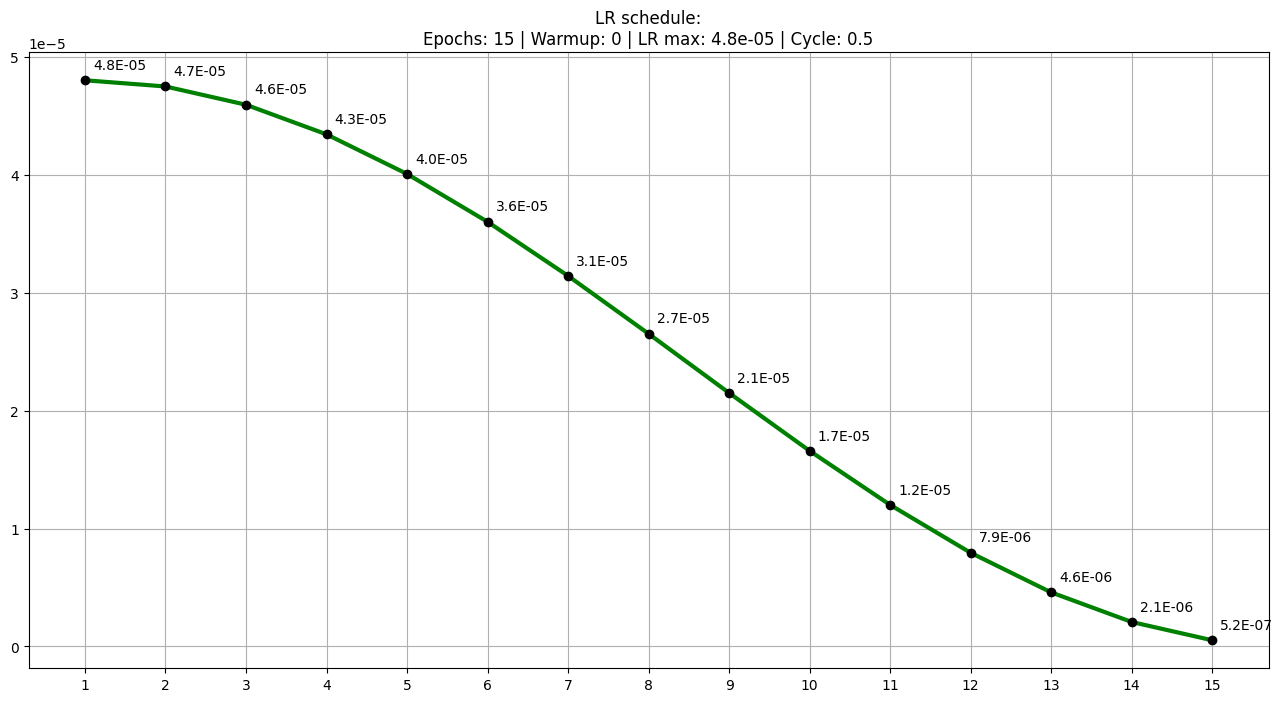

In [459]:
def lr_fn(step, epochs=15, warmup=0,
          lr_max=lr_max, cycle=0.5):
    if step < warmup:
        lr = lr_max * 0.10 ** (warmup - step)
    else:
        progress = float(step - warmup) / float(max(1, epochs - warmup))
        lr = max(0.0, 0.5 * (1.0 + np.cos(2.0 * np.pi * float(cycle) * progress))) * lr_max
    return lr


def plot_lr_schedule(epochs=15, warmup=0,
                     lr_max=lr_max, cycle=0.5):
    steps = np.array(range(epochs))
    lrs = np.vectorize(lr_fn)(steps, epochs, warmup, lr_max, cycle)
    print(lrs)
    plt.figure(figsize=(16, 8))
    plt.plot(steps + 1, lrs, '-', color='green', lw=3)
    plt.plot(steps + 1, lrs, 'o', color='black')
    offset_y = (max(lrs) - min(lrs)) * 0.02
    for x, y in zip(steps, lrs):
        plt.annotate('%.1E' % y, xy=(x+1.1, y+offset_y))
    plt.xticks(range(1, epochs + 1))
    plt.grid(True)
    plt.title(f"LR schedule:\nEpochs: {epochs} | Warmup: {warmup} | LR max: {lr_max} | Cycle: {cycle}")
    plt.show()

plot_lr_schedule()

In [455]:
lr_schedule = [lr_fn(step) for step in range(15)]
lr_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda step: lr_schedule[step], verbose=0)

In [456]:
print(train_generator.class_indices)

{'cancer': 0, 'non-cancer': 1}


In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[early_stopping, checkpoint, lr_callback]
)


In [ ]:
model.save_weights('model.hdf5')

In [126]:
model.load_weights('model.hdf5')

In [ ]:
# Assuming test_images are your test data and model is your trained model
predictions = model.predict(validation_generator)

print(len(predictions))
# Convert predictions from probabilities to class labels
predictions_labels = np.where(predictions > 0.5, 1, 0) 
np.array(validation_generator.classes)

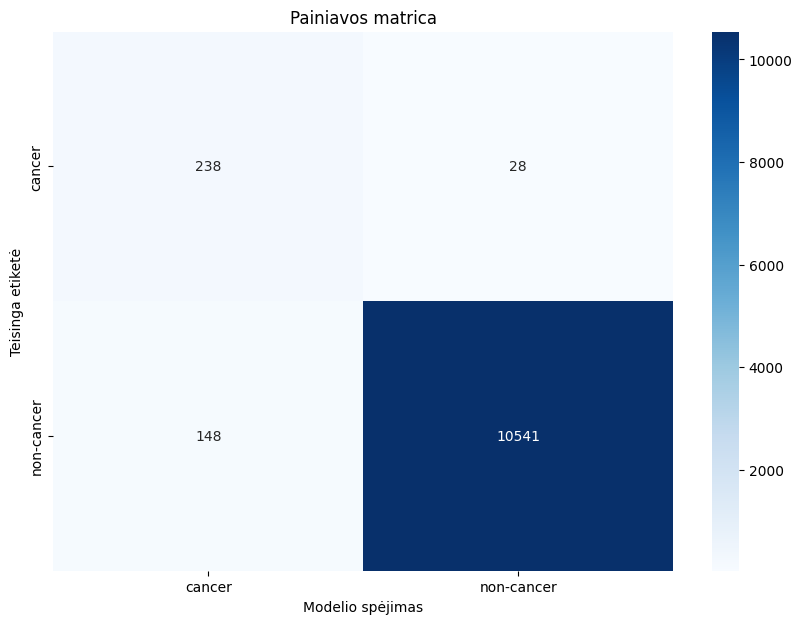

In [356]:
test_labels = validation_generator.classes
cm = confusion_matrix(test_labels, predictions_labels)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Painiavos matrica')
plt.ylabel('Teisinga etiketė')
plt.xlabel('Modelio spėjimas')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming test_labels are your true labels for your test data
# and predictions_labels are the predicted labels
print(classification_report(test_labels, predictions_labels, target_names=['cancer', 'non-cancer']))
